In [3]:
from pydeeprecsys.rl.manager import MovieLensFairnessManager
from pydeeprecsys.rl.agents.rainbow import RainbowDQNAgent
from numpy.random import RandomState
from pydeeprecsys.rl.learning_statistics import LearningStatistics
import gym
from pydeeprecsys.rl.agents.agent import RandomAgent
manager = MovieLensFairnessManager(slate_size=1)
rainbow_statistics = []
training_iterations = 1
training_episodes = 1000

In [3]:
for i in range(training_iterations):
    stats = LearningStatistics()
    rainbow_agent = RainbowDQNAgent(
        manager.env.observation_space.shape[0],
        manager.env.action_space.n,
        network_update_frequency=5,
        network_sync_frequency=250,
        batch_size=32,
        learning_rate=0.00025,
        discount_factor=0.9,
        buffer_size=10000,
        buffer_burn_in=32,
        random_state=random_state,
        statistics=stats
    )
    manager.train(rainbow_agent, max_episodes=training_episodes, statistics=stats)
    rainbow_statistics.append(stats)

Training...
Episode 299 Mean Rewards 31.83 		Training...
Episode 299 Mean Rewards 33.15 		Training...
Episode 299 Mean Rewards 31.58 		Training...
Episode 299 Mean Rewards 34.56 		Training...
Episode 299 Mean Rewards 35.86 		

In [4]:
random_statistics = []
for i in range(training_iterations):
    stats = LearningStatistics()
    random_agent = RandomAgent(gym.spaces.Discrete(3883))
    manager.train(random_agent, max_episodes=training_episodes, statistics=stats)
    random_statistics.append(stats)

Training...
Episode 299 Mean Rewards 32.76 		Training...
Episode 299 Mean Rewards 29.57 		Training...
Episode 299 Mean Rewards 32.33 		Training...
Episode 299 Mean Rewards 31.13 		Training...
Episode 299 Mean Rewards 31.55 		

In [18]:
from pydeeprecsys.rl.agents.reinforce import ReinforceAgent
reinforce_statistics = []
for i in range(training_iterations):
    stats = LearningStatistics()
    reinforce_agent = ReinforceAgent(
        state_size=manager.env.observation_space.shape[0], 
        n_actions=manager.env.action_space.n, 
        discount_factor=0.9, 
        learning_rate=0.00025)
    manager.train(reinforce_agent, max_episodes=training_episodes, statistics=stats)
    reinforce_statistics.append(stats)

Training...
Episode 299 Mean Rewards 33.25 		Training...
Episode 299 Mean Rewards 31.35 		Training...
Episode 299 Mean Rewards 30.81 		Training...
Episode 299 Mean Rewards 33.76 		Training...
Episode 299 Mean Rewards 31.19 		

In [4]:
from pydeeprecsys.rl.agents.soft_actor_critic import SoftActorCritic
sac_statistics = []
for i in range(training_iterations):
    stats = LearningStatistics()
    sac_agent = SoftActorCritic(action_space=manager.env.action_space, state_size=manager.env.observation_space.shape[0], 
        discount_factor=0.95,
        learning_rate=0.001,
        timesteps_to_start_predicting=64,
        target_update_interval=1)
    manager.train(sac_agent, max_episodes=training_episodes, statistics=stats)
    sac_statistics.append(stats)

NameError: name 'input_size' is not defined

In [19]:
import pandas
metrics = pandas.DataFrame()
for i in range(len(rainbow_statistics)):
    stats = pandas.DataFrame(rainbow_statistics[i].collected_metrics)
    stats['model'] = 'DuelingDQN'
    metrics = pandas.concat([metrics, stats])
for i in range(len(random_statistics)):
    stats = pandas.DataFrame(random_statistics[i].collected_metrics)
    stats['model'] = 'RandomAgent'
    metrics = pandas.concat([metrics, stats])
for i in range(len(reinforce_statistics)):
    stats = pandas.DataFrame(reinforce_statistics[i].collected_metrics)
    stats['model'] = 'REINFORCE'
    metrics = pandas.concat([metrics, stats])

metrics.to_csv('output/all_metrics_test.csv')

# Plot Comparison

In [20]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
metrics = pandas.read_csv('output/all_metrics_test.csv', index_col=0)
metrics = metrics.query('metric=="moving_rewards"').reset_index(drop=True)
metrics['measurement'] = metrics.measurement.astype(float)

In [21]:
metrics

,metric,measurement,timestep,episode,model,env
0,moving_rewards,44.302459,50,0,DuelingDQN,NaN
1,moving_rewards,27.551229,50,1,DuelingDQN,NaN
2,moving_rewards,33.799385,50,2,DuelingDQN,NaN
3,moving_rewards,28.951386,50,3,DuelingDQN,NaN
4,moving_rewards,28.041109,50,4,DuelingDQN,NaN
...,...,...,...,...,...,...
4495,moving_rewards,31.559441,50,295,REINFORCE,NaN
4496,moving_rewards,31.521649,50,296,REINFORCE,NaN
4497,moving_rewards,31.350144,50,297,REINFORCE,NaN
4498,moving_rewards,31.184795,50,298,REINFORCE,NaN


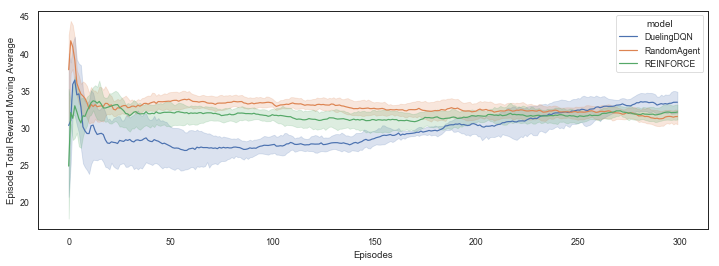

In [22]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_context("paper")
sns.set_style("white")
sns.color_palette("Set2")
plot = sns.lineplot(data=metrics, x="episode", y="measurement", hue='model', ci=95, legend='full')
plot.set(xlabel='Episodes', ylabel='Episode Total Reward Moving Average')
plt.savefig("output/preliminary_results.pdf")